In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from IPython.display import clear_output

import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
jet_pos_da = exp.jet_position_as_da()
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
props_as_df_summer = props_as_df.filter(pl.col("time").dt.month().is_in([6, 7, 8]))

In [3]:
metric = "euclidean"
nx = 6
ny = 4
exp_s = Experiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/2"))

ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")

net, centers, labels = exp_s.som_cluster(
    nx,
    ny,
    activation_distance=metric,
    return_type=RAW_REALSPACE,
    force=False,
    sigma=2,
    sigmaN=1e-5,
    train_kwargs=dict(num_epochs=20),
    init="pca"
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates
ds_center_path = exp_s.path.joinpath(f"som_{nx}_{ny}_pbc_{metric}_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds = ds.sel(time=ds.time.dt.season=="JJA")
    ds_center = labels_to_centers(labels, ds)
    ds_center.to_netcdf(ds_center_path)
else:
    ds_center = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_s.da.time, "cluster": np.arange(net.n_nodes)})

# sweep sizes again

In [56]:
from sklearn.metrics import calinski_harabasz_score
from jetstream_hugo.definitions import compute
nys = [2, 3, 4, 5, 6, 7, 8]
dys = [0, 2, 4]
# nxs = [6]
# dxs = [-2]
quant_errors = {}
topo_errors = {}
ch_indices = {}
projections = {}
X, da_weighted = exp_s.prepare_for_clustering()
da_weighted = coarsen_da(da_weighted, 1.5)
X = da_weighted.data.reshape(exp_s.data_handler.get_flat_shape()[0], -1)
X, meanX, stX = normalize(X)
X = compute(X, progress=True)
for ny in nys:
    for dy in dys:
        nx = ny + dy
        net, centers, labels = exp_s.som_cluster(
            nx,
            ny,
            activation_distance="euclidean",
            return_type=RAW_REALSPACE,
            force=False,
            init="pca",
            sigmaN=0.1,
            train_kwargs=dict(num_epochs=20),
        )
        quant_errors[(nx, ny)] = net.quantization_error(X)
        topo_errors[(nx, ny)] = net.topographic_error(X)
        ch_indices[(nx, ny)] = calinski_harabasz_score(X, labels)
        projections[(nx, ny)] = np.quantile((net.weights[labels] * X).sum(axis=1) / np.linalg.norm(net.weights, axis=1)[labels] / np.linalg.norm(X, axis=1), q=0.05)

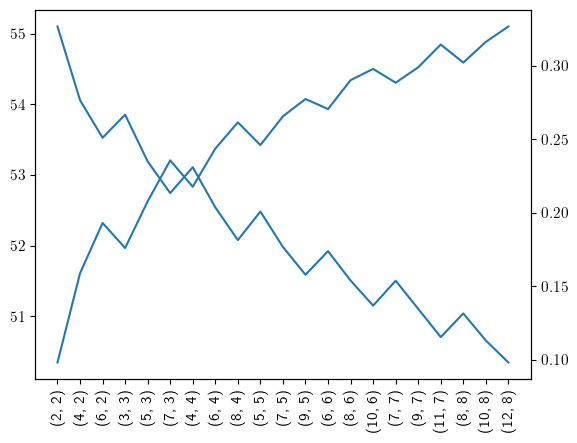

In [62]:
fig, ax = plt.subplots()
twin1 = ax.twinx()
# twin2 = ax.twinx()
# twin2.spines.right.set_position(("axes", 1.12))
ax.plot(quant_errors.values())
# twin1.plot(ch_indices.values())
twin1.plot(projections.values())
keys = list(ch_indices)
ax.set_xticks(np.arange(len(keys)), keys, ha="center")
ax.tick_params(axis='x', labelrotation=90)

# Presentation plots

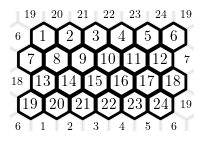

In [4]:
from matplotlib.colors import LinearSegmentedColormap
from xpysom_dask import plots as splots
from xpysom_dask.neighborhoods import Neighborhoods
outer_grid, inner_grid, coords, outermask = splots.create_outer_grid(6, 4)
nei = Neighborhoods(6, 4, "hexagons", PBC=True)
cmap = colormaps.cet_l_bmw
cmap = LinearSegmentedColormap.from_list("hoho", cmap(np.linspace(0.45, 1.0, cmap.N // 2)))
from_ = 5
# distances = nei.distances[from_, outer_grid]
distances = np.full(len(coords), np.nan)
edgecolors = np.full(len(coords), 'black', dtype=object)
edgecolors[outermask] = 'gray'
alphas = np.ones(len(coords))
alphas[outermask] = 0.05
fig, ax = splots.plot_map(
    coords, distances, 'hexagons', 
    draw_cbar=False, figsize=(0.5 * TEXTWIDTH_IN, 1.55), 
    show=False, edgecolors = 'black', cmap=None,
    alphas=alphas, linewidths=2,
)
xlims = [np.amin(coords[~outermask][:, 0]) - 0.8, np.amax(coords[~outermask][:, 0]) + 0.8]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
for i, c in enumerate(coords):
    x, y = c
    # textcolor = "white" if distances[i] < 2 else "black"
    fontsize = 8 if outermask[i] else 11
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        ax.text(x, y, f'${outer_grid.flatten()[i] + 1}$', va='center', ha='center', color="black", fontsize=fontsize)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_aspect("equal")
# ax.set_title(f"Distance to cluster {to_prettier_order(from_)}", pad=5)
plt.savefig(f"{FIGURES}/som_demo/som_numbering.png")

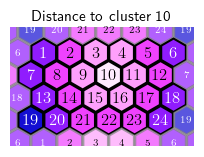

In [5]:
from matplotlib.colors import LinearSegmentedColormap
from xpysom_dask import plots as splots
from xpysom_dask.neighborhoods import Neighborhoods
outer_grid, inner_grid, coords, outermask = splots.create_outer_grid(6, 4)
nei = Neighborhoods(6, 4, "hexagons", PBC=True)
cmap = colormaps.cet_l_bmw_r
cmap = LinearSegmentedColormap.from_list("hoho", cmap(np.linspace(0.0, 0.75, cmap.N // 2)))
from_ = 9
distances = nei.distances[from_, outer_grid]
# distances = np.full(len(coords), np.nan)
edgecolors = np.full(len(coords), "black", dtype=object)
edgecolors[outermask] = 'gray'
alphas = np.ones(len(coords))
alphas[outermask] = 0.7
fig, ax = splots.plot_map(
    coords, distances, 'hexagons', 
    draw_cbar=False, figsize=(0.5 * TEXTWIDTH_IN, 1.55), 
    show=False, edgecolors = edgecolors, cmap=cmap,
    alphas=alphas, linewidths=1.5,
)
xlims = [np.amin(coords[~outermask][:, 0]) - 0.8, np.amax(coords[~outermask][:, 0]) + 0.8]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
for i, c in enumerate(coords):
    x, y = c
    textcolor = "white" if distances[i] > 2 else "black"
    fontsize = 7 if outermask[i] else 12
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        ax.text(x, y, f'${outer_grid.flatten()[i] + 1}$', va='center', ha='center', color=textcolor, fontsize=fontsize)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.set_aspect("equal")
ax.set_title(f"Distance to cluster {from_ + 1}", pad=5)
plt.savefig(f"{FIGURES}/som_demo/som_distances.png")

/scratch/local/11611211/ipykernel_1807965/1511452564.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  period = pd.date_range("20120810", "20120831", freq="6H")


(<Figure size 840x400 with 2 Axes>, <Axes: >)

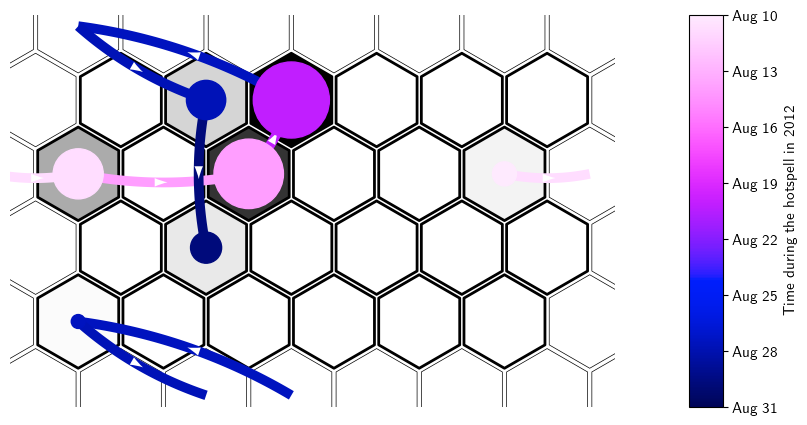

In [5]:
from matplotlib.colors import LinearSegmentedColormap
from xpysom_dask import plots as splots
from xpysom_dask.neighborhoods import Neighborhoods
period = pd.date_range("20120810", "20120831", freq="6H")
splots.plt_traj_hotspell(6, 4, period, labels)
# plt.savefig(f"{FIGURES}/som_demo/traj_pers.png")

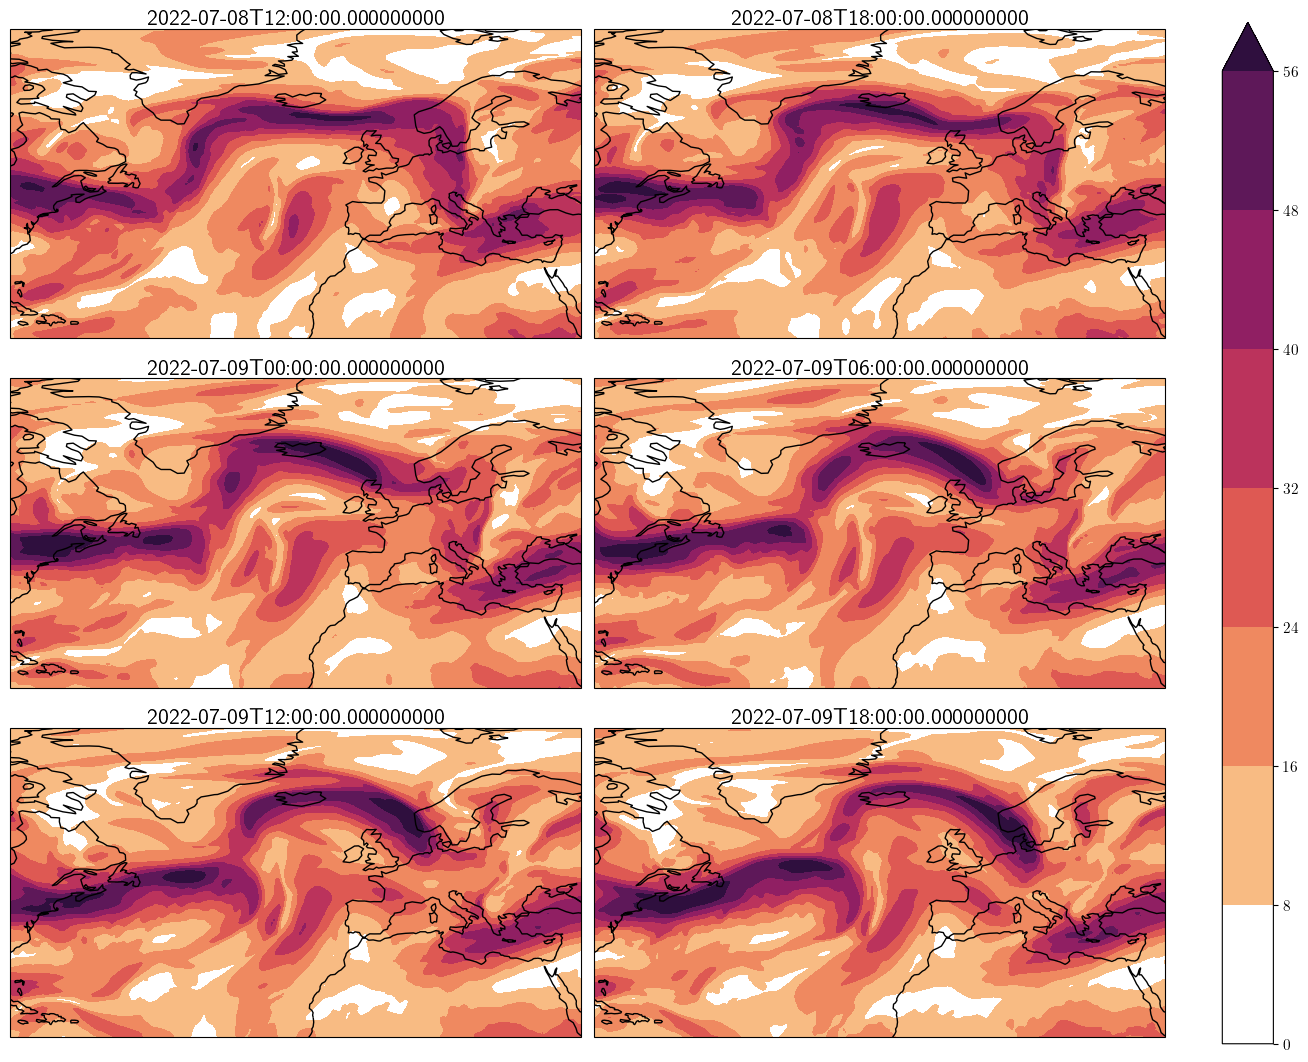

In [9]:
clu = Clusterplot(3, 2, get_region(da))
i = 23337 - 3
is_ = np.arange(i, i + 6)
_ = clu.add_contourf(da[is_], titles=da.time[is_].values, levels=7, cmap=colormaps.matter, transparify=1)
plt.savefig(f"{FIGURES}/som_demo/maps.png")

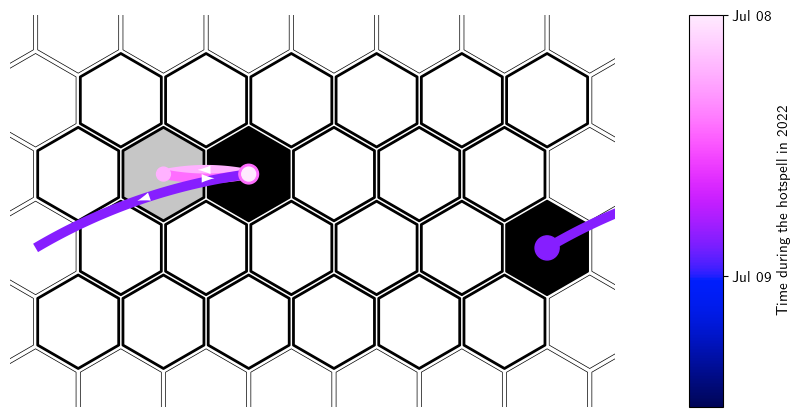

In [10]:
period = TIMERANGE[np.isin(TIMERANGE.month, [6, 7, 8])][23337 - 3:23337 + 4]
splots.plt_traj_hotspell(6, 4, period, labels)
plt.savefig(f"{FIGURES}/som_demo/traj.png")

100%|██████████| 24/24 [00:00<00:00, 366.21it/s]


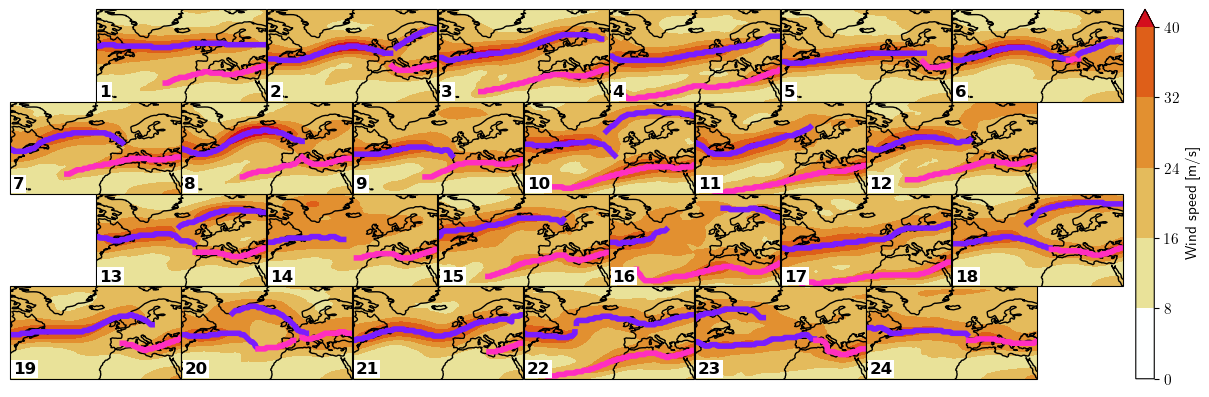

In [16]:
ds_center = ds_center.load()
df_center = pl.from_pandas(ds_center.to_dataframe().reset_index())
centers_all_jets = find_all_jets(df_center, base_s_thresh=18, alignment_thresh=0.5)
centers_all_jets = is_polar_gmix(centers_all_jets, ("lon", "lat", "lev"), n_components=2, n_init=40)

new_id = []
for clu, jets in centers_all_jets.group_by("cluster", maintain_order=True):
    njets = jets["jet ID"].n_unique()
    for idx, jet in jets.group_by("jet ID", maintain_order=True):
        new_jet_id = jet.with_columns(pl.col("jet ID") + (pl.col("is_polar") > 0.5).cast(pl.UInt16).diff().abs().fill_null(0).cum_sum().cast(pl.UInt32) * njets)
        njets = jets["jet ID"].n_unique() - 1 + new_jet_id["jet ID"].n_unique()
        new_id.append(new_jet_id.sort("lon"))
centers_all_jets = pl.concat(new_id)

centers_props_uncat = compute_jet_props(centers_all_jets)
centers_props = categorize_df_jets(centers_props_uncat, polar_cutoff=0.001)

clu = Clusterplot(net.y, net.x, get_region(da), honeycomb=True, numbering=True)
_ = clu.add_contourf(
    centers,
    cmap=colormaps.cet_l_wyor,
    # transparify=1,
    levels=[0, 8, 16, 24, 32, 40],
    cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.01}
)
for indexer, jet in centers_all_jets.group_by(["cluster", "jet ID"], maintain_order=True):
    ax = clu.axes[indexer[0]]
    is_polar = jet["is_polar"].mean() >= 0.35
    color = COLORS[2 - int(is_polar)]
    ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)
clu.resize_relative([0.95, 1])
# plt.savefig(f'{FIGURES}/som_composites/wind_and_jets.png')

# Obsolete plots

## old f6

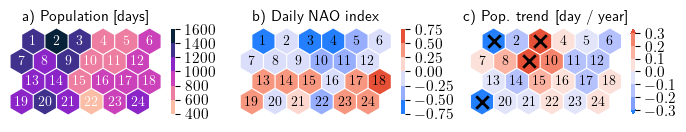

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.46), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
    linewidths=0,
)
axes[0].set_title("a) Population [days]", pad=2)
cmap = colormaps.cet_d_bwr
fig, axes[2] = net.plot_on_map(
    trends,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    norm=BoundaryNorm(np.linspace(-0.3, 0.3, 7), cmap.N, extend="both"),
    fig=fig,
    ax=axes[2],
    linewidths=0,
)
coords = net.neighborhoods.coordinates
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
axes[2].set_title("c) Pop. trend [day / year]", pad=2)
fig, axes[1] = net.plot_on_map(
    nao_on_map,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[1],
    cmap=cmap,
    # discretify=True,
    norm=BoundaryNorm(np.linspace(-0.75, 0.75, 7), cmap.N),
    linewidths=0,
)
axes[1].set_title("b) Daily NAO index", pad=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j == 0 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/pop_nao_trend.png')

In [ ]:
yearly_pops = xarray_to_polars(labels)
yearly_pops = yearly_pops.group_by(pl.col("time").dt.year().alias("year"), pl.col("labels"), maintain_order=True).len()
indexer = yearly_pops[["year"]].unique().join(yearly_pops[["labels"]].unique(), how="cross")
yearly_pops = indexer.join(yearly_pops, how="left", on=["year", "labels"]).fill_null(0).sort("year", "labels")

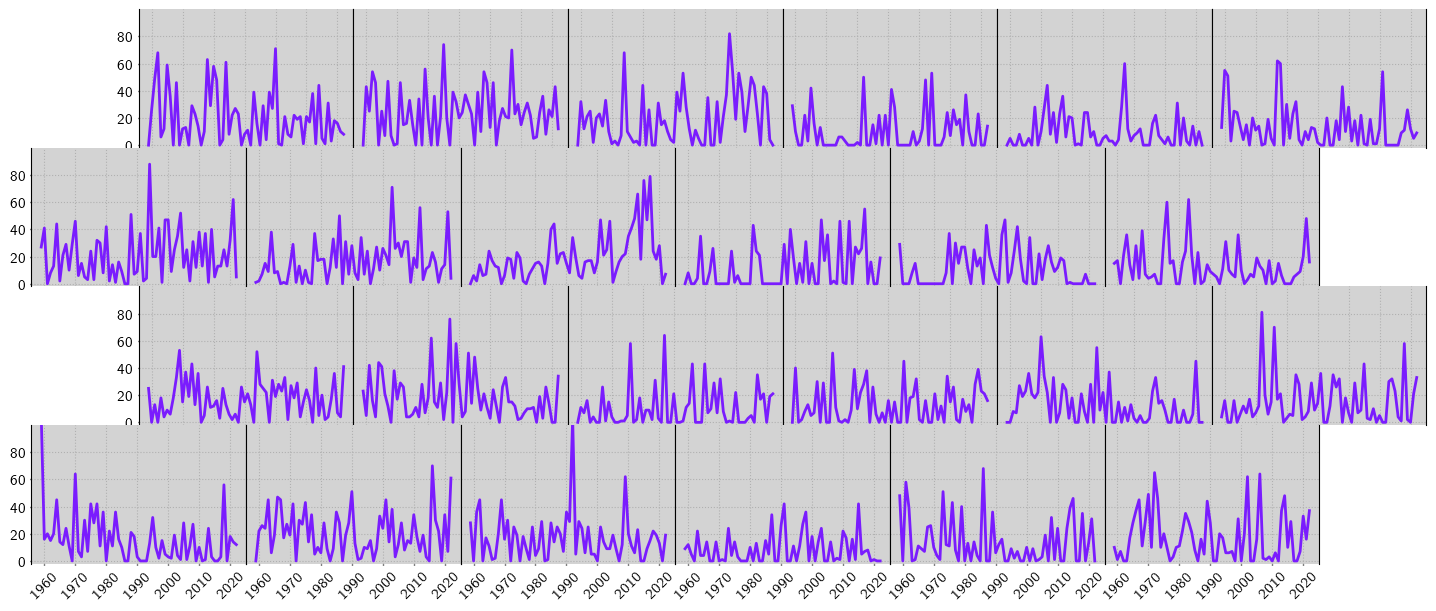

In [ ]:
fig, axes = honeycomb_panel(
    4, 6, .4
)
year_ticks = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
pop_ticks = [0, 20, 40, 60, 80]
for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
    ax.spines[["top", "bottom"]].set_visible(False)
    this_pop = yearly_pops.filter(pl.col("labels") == l)
    ax.plot(this_pop["year"], this_pop["len"], color=COLORS[1], lw=2)
    ax.grid(linestyle="dotted")
    ax.set_ylim([-2, 100])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(year_ticks, labels=year_ticks, rotation=45)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(year_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(pop_ticks, labels=pop_ticks)
        ax.tick_params(axis='y', width=1, size=1)
    else:       
        ax.set_yticks(pop_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)

## DST

In [ ]:
from CDSK import dynamical_local_indexes
X, da = exp_s.prepare_for_clustering()
X = exp_s.pca_transform(X, 100)
ld, theta, alpha = dynamical_local_indexes(X, n_jobs=10)
np.save(exp_s.path.joinpath("ld_100"), ld.squeeze())
np.save(exp_s.path.joinpath("theta_100"), theta.squeeze())

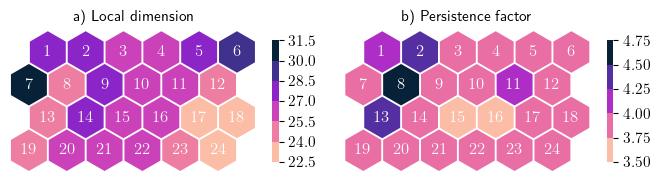

In [ ]:
ld = np.load(exp_s.path.joinpath("ld_100.npy"))
theta = np.load(exp_s.path.joinpath("theta_100.npy"))

to_plot_ld = timeseries_on_map(ld, net.bmus)[0]
to_plot_theta = timeseries_on_map(1 / theta, net.bmus)[0]

cmap = colormaps.bubblegum_r
fig, axes = plt.subplots(1, 2, figsize=(1. * TEXTWIDTH_IN, 2), tight_layout=False, subplot_kw=dict(aspect="equal"))
fig, axes[0] = net.plot_on_map(
    to_plot_ld,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Local dimension")
fig, axes[1] = net.plot_on_map(
    to_plot_theta,
    smooth_sigma=0,
    fig=fig,
    cmap=cmap,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title("b) Persistence factor")
coords = net.neighborhoods.coordinates
for i, c in enumerate(coords):
    x, y = c
    for ax in axes:
        ax.text(x, y, f'${to_prettier_order(i)}$', va='center', ha='center', color="white", fontsize=10)
fig.savefig(f'{FIGURES}/som_props/DST.png')

## PVs

In [ ]:
from jetstream_hugo.definitions import _compute
da_pvs = Experiment(DataHandler.from_specs("ERA5", "surf", "pvs", "6H", "all", "JJA", *get_region(da), 250, "hourofyear", {"hourofyear": ("win", 60)})).da
da_pvs = _compute(da_pvs, progress=True)


[########################################] | 100.00% Completed | 2.95 sms


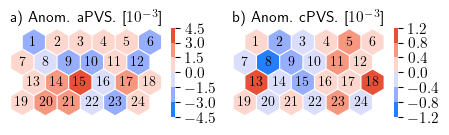

In [ ]:
time_mask = np.isin(labels.time.values, da_pvs.time.values)
to_plot_anti = np.asarray([da_pvs.loc[:, 'anti'][mask_[time_mask]].mean().item() for mask_ in mask.T])
to_plot_cycl = np.asarray([da_pvs.loc[:, 'cycl'][mask_[time_mask]].mean().item() for mask_ in mask.T])

fig, axes = plt.subplots(1, 2, figsize=(0.66 * TEXTWIDTH_IN, 1.5), tight_layout=True, subplot_kw=dict(aspect="equal"))
fig, axes[0] = net.plot_on_map(
    to_plot_anti * 1000,
    smooth_sigma=0,
    show=False,
    cmap=colormaps.cet_d_bwr,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title(r"a) Anom. aPVS. [$10^{-3}$]", pad=2)
fig, axes[1] = net.plot_on_map(
    to_plot_cycl * 1000,
    smooth_sigma=0,
    fig=fig,
    cmap=colormaps.cet_d_bwr,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title(r"b) Anom. cPVS. [$10^{-3}$]", pad=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="black", fontsize=10)
fig.savefig(f'{FIGURES}/som_props/PVS_activity.png')

## rt, $\sigma=0$

In [ ]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues = net.compute_residence_time(smooth_sigma=0, yearbreaks=yearbreak, q=0.95)

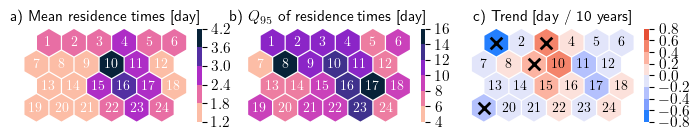

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    discretify=True,
)
axes[0].set_title("a) Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
)
axes[1].set_title("b) $Q_{95}$ of residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=colormaps.cet_d_bwr,
    discretify=True,
)
axes[2].set_title("c) Trend [day / 10 years]")
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=70, c="black", marker="x", linewidths=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j < 2 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/residence.png')

## rt, $\sigma=1$

In [ ]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues = net.compute_residence_time(smooth_sigma=0, yearbreaks=yearbreak, q=0.95)

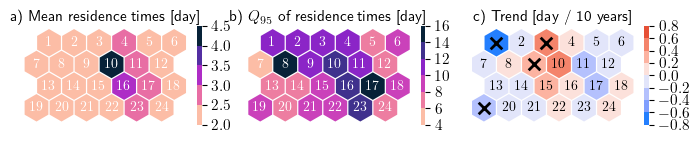

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    norm=BoundaryNorm(np.linspace(2, 4.5, 6), cmap.N, extend="neither"),
    # discretify=True,
    cbar_kwargs=dict(shrink=0.85, spacing="proportional")
)
axes[0].set_title("a) Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[1].set_title("b) $Q_{95}$ of residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=colormaps.cet_d_bwr,
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[2].set_title("c) Trend [day / 10 years]")
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=70, c="black", marker="x", linewidths=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j < 2 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/residence_sigma1.png')

## rt, real $\sigma=0.1$

In [ ]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
mean_res, max_res, trend_res, pvalues, all_lengths = net.compute_residence_time_real_sigma(smooth_sigma_quantile=0.1, yearbreaks=yearbreak, q=0.95)

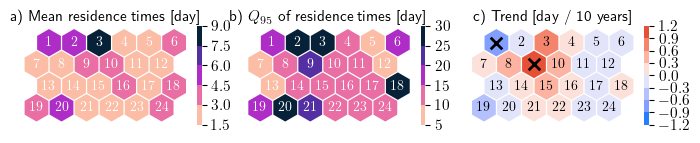

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    # norm=BoundaryNorm(np.linspace(2, 6.5, 8), cmap.N, extend="neither"),
    discretify=True,
    cbar_kwargs=dict(shrink=0.85, spacing="proportional")
)
axes[0].set_title("a) Mean residence times [day]")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[1],
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[1].set_title("b) $Q_{95}$ of residence times [day]")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap=colormaps.cet_d_bwr,
    discretify=True,
    cbar_kwargs=dict(shrink=0.85)
)
axes[2].set_title("c) Trend [day / 10 years]")
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
axes[2].scatter(*signif.T, s=70, c="black", marker="x", linewidths=2)
for i, c in enumerate(coords):
    x, y = c
    for j, ax in enumerate(axes):
        color = "white" if j < 2 else "black"
        if j == 2 and i in where_signif:
            continue
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=10)
fig.savefig(f'{FIGURES}/som_props/residence_real_sigma0.1.png')

## new rt

In [ ]:
from xpysom_dask.diagnostics import *
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(net.weights)
sigma = np.quantile(distances[distances > 0], 0.1)
spells_above_4 = get_persistent_spell_times_from_som(labels, dists=distances, sigma=sigma, nt_before=0, minlen=16, nojune=False)
spells_any = get_persistent_spell_times_from_som(labels, dists=distances, sigma=sigma, nt_before=0, minlen=1, nojune=False)

spells_per_cluster = spells_above_4.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
cmap = colormaps.bubblegum_r
n_stays = spells_per_cluster["len"].to_numpy()

mean_len_per_cluster = spells_any.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").mean())
mean_len_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(mean_len_per_cluster, how="left", on="value")
mean_len = mean_len_per_cluster["len"].to_numpy() / 4

max_len_per_cluster = spells_any.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").quantile(0.95))
max_len_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(max_len_per_cluster, how="left", on="value")
max_len = max_len_per_cluster["len"].to_numpy() / 4

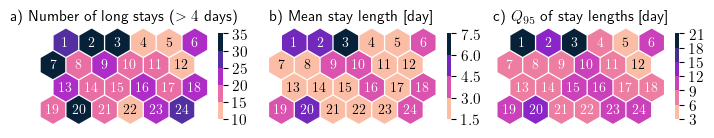

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.55), tight_layout=True, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
fig, axes[0] = net.plot_on_map(
    n_stays,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    numbering=True,
    fig=fig,
    ax=axes[0],
    discretify=True,
    cbar_kwargs=dict(shrink=0.75)
)
axes[0].set_title("a) Number of long stays ($> 4$ days)")
fig, axes[1] = net.plot_on_map(
    mean_len,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    numbering=True,
    fig=fig,
    ax=axes[1],
    discretify=True,
    cbar_kwargs=dict(shrink=0.75)
)
axes[1].set_title("b) Mean stay length [day]")
    
fig, axes[2] = net.plot_on_map(
    max_len,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    numbering=True,
    fig=fig,
    ax=axes[2],
    discretify=True,
    cbar_kwargs=dict(shrink=0.75)
)
axes[2].set_title("c) $Q_{95}$ of stay lengths [day]")
    
fig.savefig(f'{FIGURES}/som_props/residence_new.png')

## lots of line plots

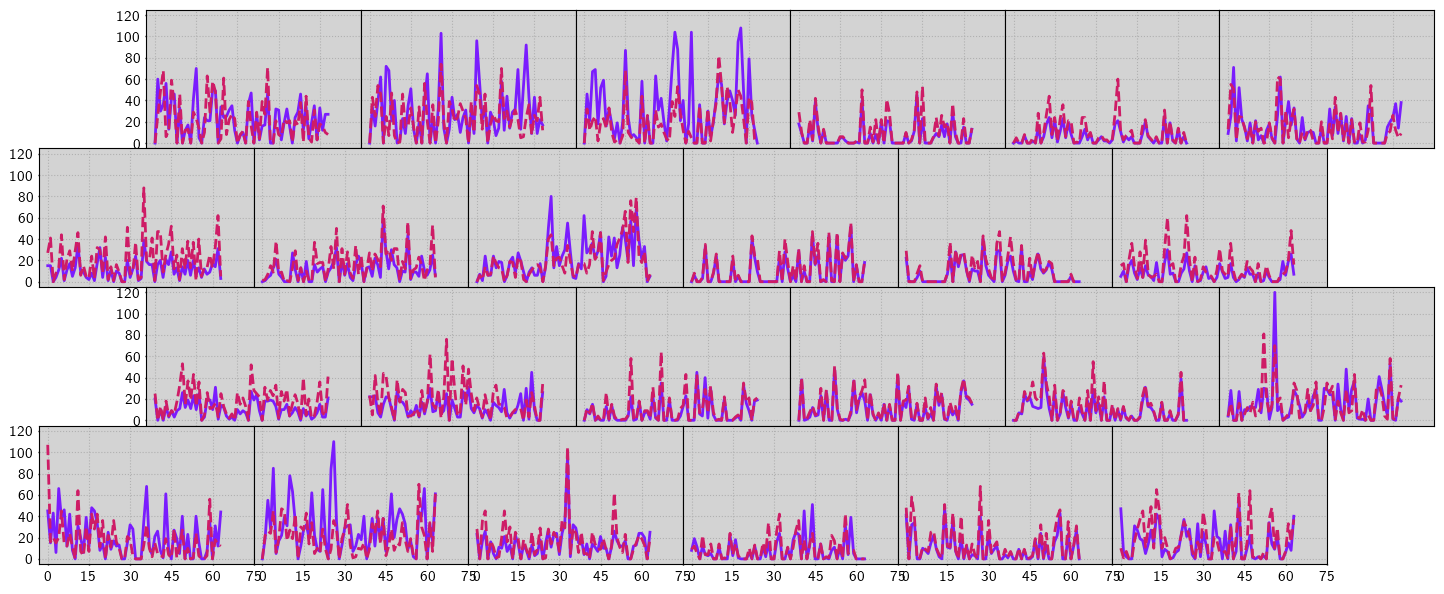

In [ ]:
yearly_pops = xarray_to_polars(labels)
yearly_pops = yearly_pops.group_by(pl.col("time").dt.year().alias("year"), pl.col("labels"), maintain_order=True).len()
indexer = yearly_pops[["year"]].unique().join(yearly_pops[["labels"]].unique(), how="cross")
yearly_pops = indexer.join(yearly_pops, how="left", on=["year", "labels"]).fill_null(0).sort("year", "labels")
res_each_year = np.zeros((24, 64), dtype=np.float32)
for i in range(24):
    for j, lens_ in enumerate(all_lengths[i]):
        res_each_year[i, j] = np.nanquantile(lens_, 0.95)
res_each_year = np.nan_to_num(res_each_year, 0).astype(np.int32)
yearly_pops = yearly_pops.with_columns(res=res_each_year.flatten(order="F"))
decadal_pop = yearly_pops.group_by((pl.col("year").rle_id() // 1).rle_id().alias("decade"), pl.col("labels"), maintain_order=True).mean()
fig, axes = honeycomb_panel(
    4, 6, .4
)
ylims = [decadal_pop["res"].min(), decadal_pop["res"].max()]
decades_ticks = MaxNLocator(6).tick_values(*decadal_pop["decade"][[0, -1]]).astype(np.int32)
pop_ticks = MaxNLocator(6).tick_values(*ylims).astype(np.int32)
for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
    this_pop = decadal_pop.filter(pl.col("labels") == l)
    ax.plot(this_pop["decade"], this_pop["res"], color=COLORS[1], lw=2)
    ax.plot(this_pop["decade"], this_pop["len"], color=COLORS[3], lw=2, ls="dashed")
    ax.grid(linestyle="dotted")
    ax.set_facecolor('lightgray')
    ax.set_ylim(ylims[0] - 5, pop_ticks[-1] + 5)
    if i == 3:
        ax.set_xticks(decades_ticks, labels=decades_ticks, rotation=0)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(decades_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(pop_ticks, labels=pop_ticks)
        ax.tick_params(axis='y', width=1, size=1)
    else:       
        ax.set_yticks(pop_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
# year_ticks = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
# pop_ticks = [0, 20, 40, 60, 80, 100]
# for (l, ax), (i, j) in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape))):
#     this_pop = yearly_pops.filter(pl.col("labels") == l)
#     ax.plot(this_pop["year"], this_pop["res"], color=COLORS[1], lw=2)
#     ax.plot(this_pop["year"], this_pop["len"], color=COLORS[3], lw=2, ls="dashed")
#     ax.grid(linestyle="dotted")
#     ax.set_ylim([-10, 120])
#     ax.set_facecolor('lightgray')
#     if i == 3:
#         ax.set_xticks(year_ticks, labels=year_ticks, rotation=45)
#         ax.tick_params(axis='x', width=1, size=1)
#     else:
#         ax.set_xticks(year_ticks, labels=[])
#         ax.tick_params(axis='x', width=0, size=0)
#     if j == 0:
#         ax.set_yticks(pop_ticks, labels=pop_ticks)
#         ax.tick_params(axis='y', width=1, size=1)
#     else:       
#         ax.set_yticks(pop_ticks, labels=[])
#         ax.tick_params(axis='y', width=0, size=0)

In [ ]:
decadal_pop

decade,labels,year,len,res
u32,i64,f64,f64,f64
0,0,1963.5,30.2,31.7
0,1,1963.5,25.4,35.2
0,2,1963.5,18.2,38.0
0,3,1963.5,13.5,10.9
0,4,1963.5,4.6,2.6
…,…,…,…,…
6,19,2020.5,25.5,27.5
6,20,2020.5,12.75,17.25
6,21,2020.5,0.25,0.0


## lagged backwards diffusion

In [ ]:
from xpysom_dask.diagnostics import *

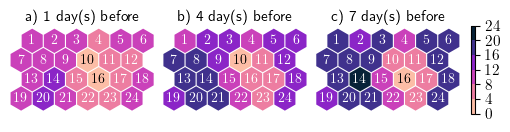

In [ ]:
yearbreak = np.sum(labels.time.dt.year.values == 1999)
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0, net.n_nodes + 4, 4), cmap.N)
im = ScalarMappable(norm, cmap)

fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
dayofsummer = labels.time.dt.dayofyear - 152 - labels.time.dt.is_leap_year.astype(int)
filter_ = (dayofsummer >= 0) & (dayofsummer <= 100)
yearbreak = int(filter_.sum() / filter_.shape[0] * 368)
for step, ax, letter in zip(steps, axes, "abc"):
    # transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    transmat = compute_transmat(labels.sel(time=filter_), n_nodes=24, yearbreaks=yearbreak, step=step)
    dilution = np.sum(transmat > 0.01, axis=0)
    fig, ax = net.plot_on_map(
        dilution,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        numbering=True,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
fig.savefig(f'{FIGURES}/som_props/dilution_before.png')

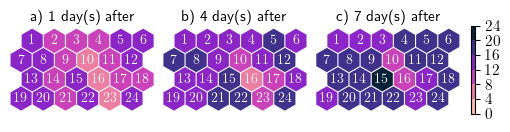

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0, net.n_nodes + 4, 4), cmap.N)
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
yearbreak = 368
for step, ax, letter in zip(steps, axes, ["a", "b", "c"]):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    dilution = np.sum(transmat > 0.01, axis=1)
    fig, ax = net.plot_on_map(
        dilution,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        numbering=True,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) after", pad=2)
fig.set_tight_layout(False)
fig.savefig(f'{FIGURES}/som_props/dilution_after.png')

## lagged backwards transitions

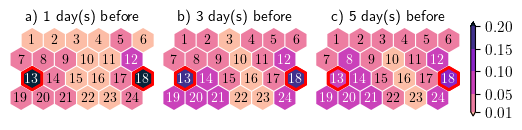

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.2), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
norm = BoundaryNorm([0.01, 0.05, 0.10, 0.15, 0.20], cmap.N, extend="both")
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, spacing="proportional", shrink=0.8, pad=0.02)
to_ = [12, 17]
coords = net.neighborhoods.coordinates
coords_subset = net.neighborhoods.coordinates[to_]
yearbreak = 368
for i, (ax, letter) in enumerate(zip(axes.ravel(), list("abcdef"))):
    step = 4 + 8 * i
    transmat = np.mean(net.compute_transmat(step=step, yearbreaks=yearbreak)[:, to_], axis=1)
    fig, ax = net.plot_on_map(
        transmat,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        numbering=True,
    )
    for j in to_:
        ax.scatter(*coords_subset.T, s=260, edgecolors="red", marker="h", linewidths=2, facecolors="none")
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
plt.savefig(f'{FIGURES}/som_props/lagged_transition_subspace.png')

## Back and forward mean distance

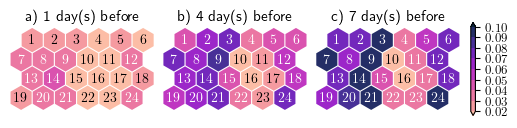

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
cmap = colormaps.bubblegum_r
norm = BoundaryNorm(np.arange(0.02, 0.11, 0.01), cmap.N, extend="both")
im = ScalarMappable(norm, cmap)
cbar = fig.colorbar(im, ax=axes, pad=0.02, shrink=0.95)
cbar.ax.tick_params(labelsize=9)
steps = [4, 16, 28]
dists = net.neighborhoods.distances
yearbreak = 368
for step, ax, letter in zip(steps, axes, list("abc")):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    mean_dists = np.zeros(net.n_nodes)
    for node, col in enumerate(transmat.T):
        mean_dists[node] = np.mean(col * dists[node])
    
    fig, ax = net.plot_on_map(
        mean_dists,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        numbering=True,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) before", pad=2)
fig.set_tight_layout(False)
fig.savefig(f'{FIGURES}/som_props/distance_dilution_before.png')

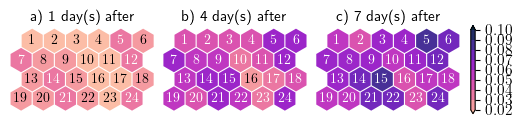

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(TEXTWIDTH_IN, 1.), gridspec_kw=dict(wspace=0.06, hspace=0.02, bottom=0.00, top=0.98), tight_layout=False, subplot_kw=dict(aspect="equal"))
axes = axes.ravel()
norm = BoundaryNorm(np.arange(0.02, 0.11, 0.01), cmap.N, extend="both")
im = ScalarMappable(norm, cmap)
fig.colorbar(im, ax=axes, pad=0.02, shrink=0.9)
steps = [4, 16, 28]
dists = net.neighborhoods.distances
yearbreak = 368

for step, ax, letter in zip(steps, axes, list("abc")):
    transmat = net.compute_transmat(step=step, yearbreaks=yearbreak)
    mean_dists = np.zeros(net.n_nodes)
    for node, line in enumerate(transmat):
        mean_dists[node] = np.mean(line * dists[node])
    
    fig, ax = net.plot_on_map(
        mean_dists,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        numbering=True,
    ) 
    ax.set_title(f"{letter}) {step // 4} day(s) after", pad=2)
fig.set_tight_layout(False)
fig.savefig(f'{FIGURES}/som_props/distance_dilution_after.png')

In [ ]:
lag_distances = []
conv = False
lag = 1
while not conv:
    transmat = net.compute_transmat(step=lag, yearbreaks=yearbreak)
    these_distances = net.neighborhoods.distances[np.arange(24), np.argmax(transmat, axis=1)]
    conv = np.all(these_distances > 0)
    lag_distances.append(net.neighborhoods.distances[np.arange(24), np.argmax(transmat, axis=1)])
    lag = lag + 1
lag_distances = np.asarray(lag_distances)

(<Figure size 500x400 with 2 Axes>, <Axes: >)

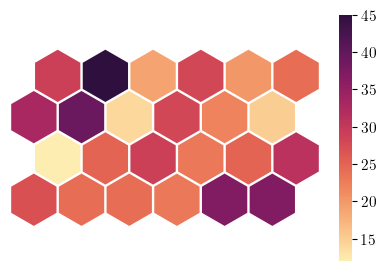

In [ ]:
net.plot_on_map(np.argmax(lag_distances > 0, axis=0))

In [ ]:
lag_distances = []
conv = False
lag = 1
while not conv:
    transmat = net.compute_transmat(step=lag, yearbreaks=yearbreak)
    these_distances = net.neighborhoods.distances[np.argmax(transmat, axis=0), np.arange(24)]
    conv = np.all(these_distances > 0)
    lag_distances.append(these_distances)
    lag = lag + 1
lag_distances = np.asarray(lag_distances)

(<Figure size 500x400 with 2 Axes>, <Axes: >)

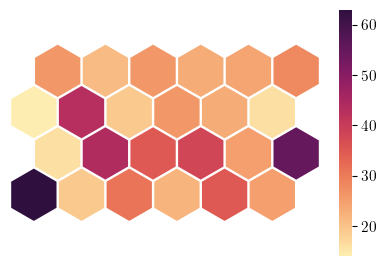

In [ ]:
net.plot_on_map(np.argmax(lag_distances > 0, axis=0))

# Main plots

## Typical summer pathway

In [18]:
timestepwise = []
group = [] 
for i, (_, group_) in enumerate(labels.groupby(labels.time.dt.dayofyear).groups.items()):
    group.append(group_)
    if i % 7 != 6:
        continue
    group = np.concatenate(group)
    coords = net.neighborhoods.coordinates[labels[group]]
    unique, count = np.unique(labels[group], return_counts=True)
    
    coordsmax = coords.max(axis=0, keepdims=True)
    thetas = coords / coordsmax * 2 * np.pi
    xi, zeta = np.cos(thetas), np.sin(thetas)
    mxi, mzeta = np.mean(xi, axis=0), np.mean(zeta, axis=0)
    com = np.arctan2(-mzeta, -mxi) + np.pi
    com = com / 2 / np.pi * coordsmax
    
    maxdx = net.x
    maxdy = net.y
    dx = np.abs(coords[:, 0] - com[0, 0])
    dy = np.abs(coords[:, 1] - com[0, 1])
    mask_periodic = dx > maxdx
    dx[mask_periodic] = maxdx - dx[mask_periodic]
    mask_periodic = dy > maxdy
    dy[mask_periodic] = maxdy - dy[mask_periodic]
    stdx = np.sqrt(np.sum(dx ** 2) / (len(dx) - 1))
    stdy = np.sqrt(np.sum(dy ** 2) / (len(dy) - 1))
    variab = np.asarray([stdx, stdy])
    timestepwise.append((com.squeeze(), variab.squeeze(), unique, count))
    group = []
    
com = np.asarray([step_[0] for step_ in timestepwise])
com_std = np.asarray([step_[1] for step_ in timestepwise])

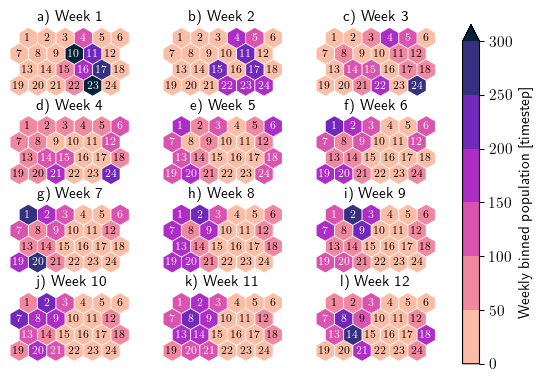

In [19]:
fig, axes = plt.subplots(4, 3, figsize=(TEXTWIDTH_IN, 4.4), tight_layout=False, subplot_kw={"aspect": "equal"})
cmap = colormaps.bubblegum_r
max_ = np.quantile([np.amax(timestepwis[3]) for timestepwis in timestepwise], 0.8)
norm = BoundaryNorm(MaxNLocator(6).tick_values(0, max_), cmap.N, extend="max")
im = ScalarMappable(norm, cmap)
coords = net.neighborhoods.coordinates
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_ylabel("Weekly binned population [timestep]")
for i, ax in enumerate(axes.ravel()):
    step = i + 1
    letter = ascii_lowercase[i]
    unique, counts = timestepwise[step][2], timestepwise[step][3]
    to_plot = np.zeros(net.n_nodes)
    to_plot[unique] = counts
    fig, ax = net.plot_on_map(
        to_plot,
        smooth_sigma=0,
        show=False,
        cmap=cmap,
        norm=norm,
        fig=fig,
        ax=ax,
        draw_cbar=False,
        linewidths=0,
    )
    # ax.errorbar(*com[step], *com_std[step][[1, 0]])
    ax.set_title(f"{letter}) Week {step}", pad=2)
    
    for i, c in enumerate(coords):
        x, y = c
        color = "white" if to_plot[i] > 100 else "black"
        ax.text(x, y, f'${i + 1}$', va='center', ha='center', color=color, fontsize=8)
fig.set_tight_layout(False)
plt.savefig(f"{FIGURES}/som_props/weekly_pathway.png")

### SOM COM lol

In [52]:
np.amax([np.amax(timestepwis[3]) for timestepwis in timestepwise]) / 4

np.float64(159.5)

In [22]:
coords = net.neighborhoods.coordinates
com_t = np.asarray(list(map(tuple, com)), dtype="f,f")
coords_t = np.asarray(list(map(tuple, coords)), dtype="f,f")

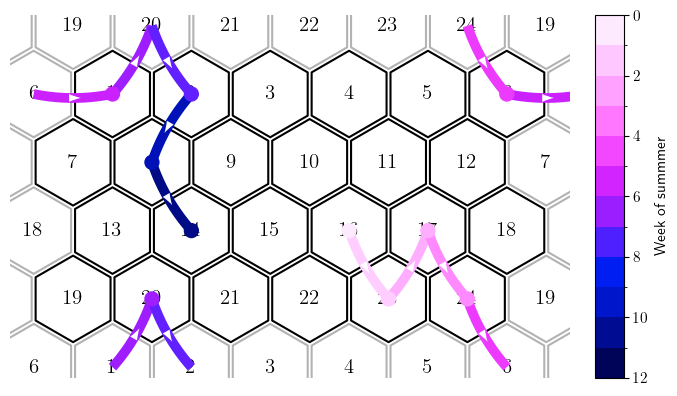

In [23]:
from xpysom_dask.plots import create_outer_grid, traj_to_segments, segments_to_arcs, plot_map
from matplotlib.collections import PatchCollection, LineCollection

outer_grid, inner_grid, coords, outermask = create_outer_grid(net.x, net.y)
edgecolors = np.full(len(coords), "black", dtype=object)
edgecolors[outermask] = "black"
alphas = np.ones(len(coords))
alphas[outermask] = 0.3

traj = []
for step_ in timestepwise:
    unique, counts = step_[2:]
    traj.append(unique[np.argmax(counts)])
traj = np.asarray(traj)   
# traj = np.argmin(pairwise_distances(com, net.neighborhoods.coordinates), axis=1) 
traj_split = np.split(traj, np.where((np.diff(traj) != 0))[0] + 1)
sizes = np.asarray([len(stay) for stay in traj_split])
uniques = np.asarray([stay[0] for stay in traj_split])
color_array = np.asarray([0, *np.cumsum(sizes)], dtype=int)
cmap = colormaps.cet_l_bmw1_r
colors = cmap(np.linspace(0, 1, len(traj) + 1))[color_array]
sort_like = np.argsort(sizes)[::-1]
    
segments, reps = traj_to_segments(traj_split, coords, outer_grid, outermask)
arcs, arrows = segments_to_arcs(segments)

gs = plt.GridSpec(
    1,
    3,
    width_ratios=[1, 0.02, 0.05],
    wspace=0.01,
    left=0.01,
    right=0.9,
    bottom=0.01,
    top=0.99,
)
fig = plt.figure(figsize=(TEXTWIDTH_IN, 3.7))
ax = fig.add_subplot(gs[0], aspect="equal")
ax_cbar = fig.add_subplot(gs[2])
inner_coords = coords[~outermask]
xlims = [
    np.amin(inner_coords[:, 0]) - 0.8,
    np.amax(inner_coords[:, 0]) + 0.8,
]
ylims = [
    np.amin(inner_coords[:, 1]) - 1,
    np.amax(inner_coords[:, 1]) + 1,
]

fig, ax = plot_map(
    coords,
    np.zeros(len(coords)) + np.nan,
    "hexagons",
    draw_cbar=False,
    show=False,
    edgecolors=edgecolors,
    alphas=alphas,
    linewidths=1.5,
    fig=fig,
    ax=ax,
)
for i, c in enumerate(coords):
    x, y = c
    if x > xlims[0] and x < xlims[-1] and y > ylims[0] and y < ylims[-1]: 
        ax.text(x, y, f'${outer_grid.flatten()[i] + 1}$', va='center', ha='center', color="black", fontsize=15)
lc = LineCollection(arcs, colors=np.repeat(colors[1:-1], reps, axis=0), zorder=3)
lc.set_linewidth(7)
lc = ax.add_collection(lc)
arrows = PatchCollection(arrows, zorder=9, edgecolor=None, facecolor="white")
ax.add_collection(arrows)
im = ScalarMappable(BoundaryNorm(np.arange(0, len(traj)), cmap.N), cmap)
cbar = fig.colorbar(
    im,
    cax=ax_cbar,
    label="Week of summmer"
)
uniques = uniques[sort_like]
sizes = sizes[sort_like]
colors = colors[:-1][sort_like]
ax.scatter(*coords[~outermask][uniques].T, s=100, c=colors, zorder=10)
colors = cmap(np.linspace(0, 1, len(com)))
# for color, com_, com_std_ in zip(colors, com, com_std):
#     com_ = com_ + np.asarray([ 4., 3.4641 ])
#     ax.errorbar(*com_, *com_std_[[1, 0]], zorder=10, color=color)
ax_cbar.invert_yaxis()
ax.set_xlim(xlims)
ax.set_ylim(ylims)
plt.savefig(f"{FIGURES}/som_props/track_com.png")

## Fig 6

In [9]:
from scipy.stats import linregress
from sklearn.metrics import pairwise_distances

da = exp_s.da
df = pd.read_csv(f"{DATADIR}/ERA5/daily_nao.csv", delimiter=",")
index = pd.to_datetime(df.iloc[:, :3])
series = xr.DataArray(df.iloc[:, 3].values, coords={"time": index})
nao_summer = series.interp_like(da)
nao_on_map = timeseries_on_map(nao_summer, net.latest_bmus)[0]

yearly = mask_da.resample(time="1YE").sum().values
trends = np.zeros(net.n_nodes)
pvalues = trends.copy()
for k, yearly_ in enumerate(yearly.T):
    trends[k], _, _, pvalues[k], _ = linregress(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0]
    )

X, da_weighted = exp_s.prepare_for_clustering()
da_weighted = coarsen_da(da_weighted, 1.5)
X = da_weighted.data.reshape(exp_s.data_handler.get_flat_shape()[0], -1)
X, meanX, stX = normalize(X)
X = compute(X, progress_flag=True)

RMSE = np.zeros(net.n_nodes)
for i in trange(net.n_nodes):
    w = net.weights[i].flatten()[None, :]
    mask_ = labels.data == i
    x = X[mask_] .reshape(np.sum(mask_), -1) 
    RMSE[i] = np.mean(pairwise_distances(x, w))
    
from sklearn.metrics import pairwise_distances
separatedness = pairwise_distances(net.weights) / net.neighborhoods.distances
separatedness = np.nanmean(separatedness, axis=1)

100%|██████████| 24/24 [00:00<00:00, 48.79it/s]
/scratch/local/14413566/ipykernel_2582638/3597902789.py:33: RuntimeWarning: invalid value encountered in divide
  separatedness = pairwise_distances(net.weights) / net.neighborhoods.distances


In [10]:
dh = DataHandler.from_specs("ERA5", "plev", "z", "6H", "all", "JJA", -80, 40, 15, 80, 500, "dayofyear", {"dayofyear": ("win", 90)}, None)
exp_z = Experiment(dh)
centers_z, labels_z = exp_z.do_kmeans(4, 30, weigh_grams=False)

coslat = np.cos(np.deg2rad(centers_z.lat))
Pwr = (exp_z.da * centers_z * coslat).sum(["lon", "lat"]) / coslat.sum() / centers_z.lon.shape[0]
Iwr = (Pwr - Pwr.mean("time")) / Pwr.std("time", ddof=0)
Iwr = compute(Iwr)
Iwr = xarray_to_polars(Iwr.rename("Iwr")).drop("ratio", "label")

# Iwr = Iwr.with_columns(year=pl.col("time").dt.year())
sigma_wr = Iwr["Iwr"].std()
winner = Iwr.group_by("time", maintain_order=True).agg(pl.col("Iwr").arg_max().alias("winner"), pl.col("Iwr").max(), pl.col("time").dt.year().alias("year").first())
winner = winner.with_columns(winner=pl.when(pl.col("Iwr") > sigma_wr).then(1 + pl.col("winner")).otherwise(pl.lit(0)))
start_of_year = winner.group_by("year", maintain_order=True).len().with_columns(start_of_year=pl.col("len").cum_sum() - pl.col("len").get(0)).drop("len")
to_zero = (
    winner
    .group_by("year", maintain_order=True)
    .agg(pl.col("winner").rle().alias("rle"))
    .explode("rle")
    .unnest("rle")
    .group_by("year", maintain_order=True)
    .agg(
        len=pl.col("len"),
        start=pl.lit(0).append(
            pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)
        ),
        value=pl.col("value"),
    )
    .explode(["len", "start", "value"])
    .join(start_of_year, on="year")
    .with_columns(start=pl.col("start") + pl.col("start_of_year"))
    .drop("start_of_year")
    .filter(pl.col("len") < 20, pl.col("value") > 0)
    .drop("value")
    .with_columns(
        index=pl.int_ranges(pl.col("start"), pl.col("start") + pl.col("len"))
    )
    .drop("len", "start")
    .explode("index")
)[:, "index"]
winner[to_zero, "winner"] = 0

mask_updated = labels_to_mask(winner[:, "winner"].to_numpy())

s_and_z = (mask[:, :, None] & mask_updated[:, None, :])

100%|██████████| 4/4 [00:09<00:00,  2.40s/it]


In [11]:
titles_wr = [
    "N-",
    "AR",
    "AL",
    "SB",
    "No regime",
]
order_to_plot = [1, 2, 3, 4, 0]
titles_wr_with_props = [f"{letter}) {title}, (${prop * 100:.1f} \%$)" for letter, title, prop in zip(list("efghi"), titles_wr, mask_updated.mean(axis=0)[order_to_plot])]
s_and_z_means = s_and_z.mean(axis=0) / mask.mean(axis=0)[:, None]
s_and_z_means = s_and_z_means[:, order_to_plot]
majority = np.argmax(s_and_z_means[:, :4], axis=1)
no_regime = mask_updated.mean(axis=0)[0]

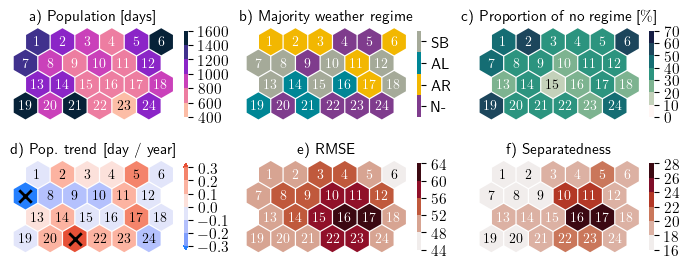

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(TEXTWIDTH_IN , 2 * 1.46), tight_layout=True, subplot_kw=dict(aspect="equal"))

to_plot_dict = {
    "a) Population [days]": (populations, colormaps.bubblegum_r, True, True, {}),
    # "b) Majority weather regime": (majority, colormaps.bold, BoundaryNorm(np.arange(-0.5, 4.5), colormaps.bold.N, extend="neither"), True, {"ticks": np.arange(4), "ticklabels": titles_wr[:-1]}),
    "b) Majority weather regime": (majority, colormaps.bold, False, True, {"ticks": np.arange(4), "ticklabels": titles_wr[:-1], "boundaries": np.arange(-0.5, 4.5)}),
    "c) Proportion of no regime [$\%$]": (s_and_z_means[:, -1] * 100, colormaps.tempo, BoundaryNorm(np.arange(0, 80, 10), colormaps.tempo.N, extend="neither"), True, {}),
    "d) Pop. trend [day / year]": (trends, colormaps.cet_d_bwr, BoundaryNorm(np.linspace(-0.3, 0.3, 7), colormaps.cet_d_bwr.N, extend="both"), False, {}),
    "e) RMSE": (RMSE, colormaps.amp, True, True, {}),
    "f) Separatedness" : (separatedness, colormaps.amp, True, True, {}),
} 
for ax, (title, to_plot) in zip(axes.ravel(), to_plot_dict.items()):
    to_plot, cmap, discretify, numbering, more_cbar_kwargs = to_plot
    if isinstance(discretify, bool):
        discretify = discretify
        norm = None
    else:
        norm = discretify
        discretify = False
    fig, ax = net.plot_on_map(
        to_plot,
        fig=fig,
        ax=ax,
        cmap=cmap,
        norm=norm,
        discretify=discretify,
        numbering=numbering,
        cbar_kwargs={"shrink": 0.7} | more_cbar_kwargs
    )
    ax.set_title(title)
    
coords = net.neighborhoods.coordinates
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
ax = axes.ravel()[3]
ax.scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
for i, c in enumerate(coords):
    x, y = c
    if i in where_signif:
        continue
    ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="black", fontsize=10)
# fig.savefig(f'{FIGURES}/som_props/fig06_new.png')

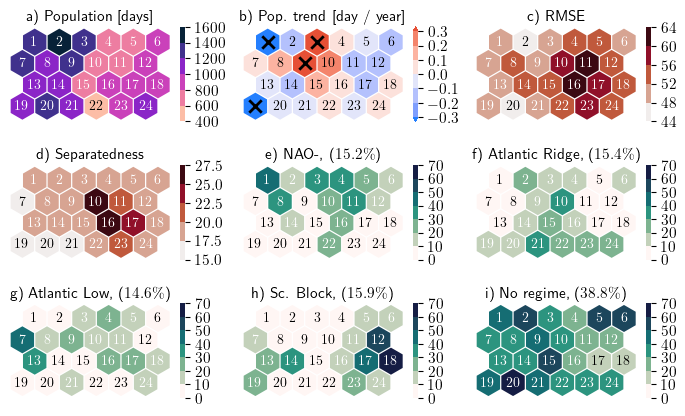

In [19]:
fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 3 * 1.46), tight_layout=True, subplot_kw=dict(aspect="equal"))

to_plot_dict = {
    "a) Population [days]": (populations, colormaps.bubblegum_r, True, True),
    "b) Pop. trend [day / year]": (trends, colormaps.cet_d_bwr, BoundaryNorm(np.linspace(-0.3, 0.3, 7), colormaps.cet_d_bwr.N, extend="both"), False),
    "c) RMSE": (RMSE, colormaps.amp, True, True),
    "d) Separatedness" : (separatedness, colormaps.amp, True, True),
} | {
    title_wr: (this_sz * 100, colormaps.tempo, BoundaryNorm(np.arange(0, 80, 10), colormaps.tempo.N, extend="neither"), True) for title_wr, this_sz in zip(titles_wr, s_and_z_means.T)
}
for ax, (title, to_plot) in zip(axes.ravel(), to_plot_dict.items()):
    to_plot, cmap, discretify, numbering = to_plot
    if isinstance(discretify, bool):
        discretify = discretify
        norm = None
    else:
        norm = discretify
        discretify = False
    fig, ax = net.plot_on_map(
        to_plot,
        fig=fig,
        ax=ax,
        cmap=cmap,
        norm=norm,
        discretify=discretify,
        numbering=numbering,
        cbar_kwargs={"shrink": 0.75}
    )
    ax.set_title(title)
    
coords = net.neighborhoods.coordinates
where_signif = np.where(pvalues < 0.05)[0]
signif = net.neighborhoods.coordinates[where_signif]
ax = axes.ravel()[1]
ax.scatter(*signif.T, s=80, c="black", marker="x", linewidths=2.)
for i, c in enumerate(coords):
    x, y = c
    if i in where_signif:
        continue
    ax.text(x, y, f'${i + 1}$', va='center', ha='center', color="black", fontsize=10)
# fig.savefig(f'{FIGURES}/som_props/fig06.png')

## new rt

In [4]:
from xpysom_dask.diagnostics import *
from sklearn.metrics import pairwise_distances

distances = pairwise_distances(net.weights)
sigma = np.quantile(distances[distances > 0], 0.1)
spells_above_4 = get_persistent_spell_times_from_som(labels, dists=distances, sigma=sigma, nt_before=0, minlen=16, nojune=False)
spells_any = get_persistent_spell_times_from_som(labels, dists=distances, sigma=sigma, nt_before=0, minlen=1, nojune=False)

spells_per_cluster = spells_above_4.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
cmap = colormaps.bubblegum_r
n_stays = spells_per_cluster["len"].to_numpy()

mean_len_per_cluster = spells_any.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").mean())
mean_len_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(mean_len_per_cluster, how="left", on="value")
mean_len = mean_len_per_cluster["len"].to_numpy() / 4

max_len_per_cluster = spells_any.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").quantile(0.95))
max_len_per_cluster = pl.Series("value", np.arange(24)).to_frame().join(max_len_per_cluster, how="left", on="value")
max_len = max_len_per_cluster["len"].to_numpy() / 4

plot_on_map = [
    {
        "title": "\# of long stays ($> 4$ days)",
        "data": n_stays,
        "cmap": colormaps.bubblegum_r,
    },
    {
        "title": "Mean residence time [day]",
        "data": mean_len,
        "cmap": colormaps.bubblegum_r,
    },
    {
        "title": "$Q_{95}$ of residence times [day]",
        "data": max_len,
        "cmap": colormaps.bubblegum_r,
    },
]

ds_center = ds_center.load()
df_center = pl.from_pandas(ds_center.to_dataframe().reset_index())
centers_all_jets = find_all_jets(df_center, base_s_thresh=18, alignment_thresh=0.5)
centers_all_jets = is_polar_gmix(centers_all_jets, ("lon", "lat", "lev"), n_components=2, n_init=40)

new_id = []
for clu, jets in centers_all_jets.group_by("cluster", maintain_order=True):
    njets = jets["jet ID"].n_unique()
    for idx, jet in jets.group_by("jet ID", maintain_order=True):
        new_jet_id = jet.with_columns(pl.col("jet ID") + (pl.col("is_polar") > 0.5).cast(pl.UInt16).diff().abs().fill_null(0).cum_sum().cast(pl.UInt32) * njets)
        njets = jets["jet ID"].n_unique() - 1 + new_jet_id["jet ID"].n_unique()
        new_id.append(new_jet_id.sort("lon"))
centers_all_jets = pl.concat(new_id)

centers_props_uncat = compute_jet_props(centers_all_jets)
centers_props = categorize_df_jets(centers_props_uncat, polar_cutoff=0.1)

jet_pos_da_centers = jet_position_as_da(centers_all_jets)
centers_props = get_double_jet_index(centers_props, jet_pos_da_centers)
centers_props = centers_props.with_columns(centers_props["tilt"].clip(0, 1))

data_vars_and_jets = [
    ("persistence", "STJ", colormaps.flamingo_r),
    ("persistence", "EDJ", colormaps.gothic_r),
    ("com_speed", "STJ", colormaps.flamingo),
    ("com_speed", "EDJ", colormaps.gothic),
]

for (varname, jet, cmap) in data_vars_and_jets:
    title = f"{jet} {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]"
    data = props_as_df_summer.filter(pl.col("jet") == jet)[varname]
    data = timeseries_on_map(data, net.latest_bmus)[0]
    dico = {
        "title": title,
        "data": data,
        "cmap": cmap,
    }
    plot_on_map.append(dico)

100%|██████████| 24/24 [00:00<00:00, 473.84it/s]


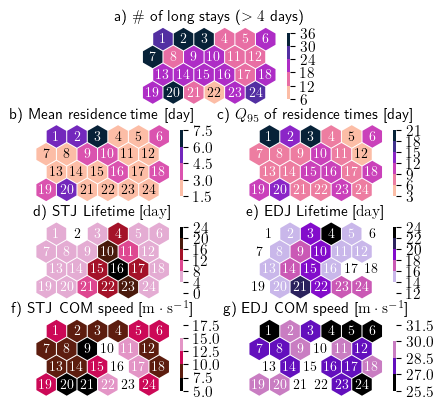

In [5]:
# fig, axes = plt.subplots(4, 2, figsize=(TEXTWIDTH_IN * 0.66, 3.9), tight_layout=True, gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), subplot_kw=dict(aspect="equal"))
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(TEXTWIDTH_IN * 0.63, 3.9))
gs = GridSpec(4, 4, wspace=0.03, hspace=0.18, bottom=0.02, top=0.98, left=0.02, right=0.98)
axes = np.empty(7, dtype=object)
subplot_kw=dict(aspect="equal")
axes[0] = fig.add_subplot(gs[0, slice(1, 3)], **subplot_kw)
for i in range(1, 7):
    iprim = ((i + 1) % 2) * 2
    axes[i] = fig.add_subplot(gs[1 + (i - 1) // 2, slice(0 + iprim, 2 + iprim)], **subplot_kw)
fig.set_tight_layout(False)
axes = axes.ravel()
for ax, dico, letter in zip(axes, plot_on_map, "abcdefg"):
    title = dico["title"]
    fig, ax = net.plot_on_map(
        **dico,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        discretify=True,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.8),
        numbering=True,
    )
    ax.set_title(f"{letter}) {title}")
fig.set_tight_layout(False)
fig.savefig(f'{FIGURES}/som_props/residence_newnew.png')

## jet indices

In [23]:
widths = compute_widths(centers_all_jets, ds_center["s"])

cluster,jet ID,width
i64,u32,f32
0,1,1.873672e6
5,1,1.1340e6
14,0,913707.625
15,3,220819.34375
19,2,299807.3125
…,…,…
20,1,222140.09375
15,1,220842.3125
19,0,222389.625


In [26]:
centers_props

cluster,jet,mean_lon,mean_lat,mean_lev,mean_theta,mean_s,lon_star,lat_star,s_star,lon_ext,lat_ext,tilt,waviness1,waviness2,wavinessR16,wavinessDC16,wavinessFV15,int,int_over_europe,is_polar,njets,double_jet_index
i64,str,f32,f32,f32,f64,f32,f32,f32,f32,f32,f32,f64,f64,f32,f32,f32,f32,f32,f32,f64,u8,f64
0,"""STJ""",17.154581,44.093674,211.767136,350.298033,33.720081,14.0,43.0,35.808109,44.0,3.0,0.086423,0.429071,81.280006,0.090909,0.018593,0.003701,1.26461336e8,1.26461336e8,0.033568,1,0.032787
0,"""EDJ""",-40.7883,47.966255,232.061722,339.330957,31.702841,-57.0,46.0,36.602249,75.0,9.0,0.098892,4.266837,788.55365,0.293333,0.022704,-0.009484,2.29203808e8,3.5734776e7,0.992528,1,0.032787
1,"""STJ""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0.0
1,"""EDJ""",-22.961508,50.097195,233.64502,338.733975,34.721058,-47.0,52.0,41.508728,119.0,14.0,0.069533,10.259569,2047.564575,0.252101,0.021171,-0.003217,3.56890144e8,1.26216728e8,0.99571,1,0.0
2,"""STJ""",29.741943,38.899555,209.918549,355.521274,30.740225,39.0,41.0,33.778107,20.0,4.0,0.18976,0.378768,44.038452,0.25,0.020215,0.008466,6.1574012e7,6.1574012e7,0.000031,1,0.147541
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
21,"""EDJ""",-25.018948,49.970966,248.084091,334.117431,34.13945,-25.0,52.999996,41.294056,114.0,15.0,0.096918,6.67677,2256.55542,0.263158,0.021352,0.000093,3.41224832e8,1.06159048e8,1.0,1,0.901639
22,"""STJ""",-9.898347,27.437027,199.31778,347.244416,30.825958,39.0,35.0,37.895321,108.0,17.0,0.179781,1.874509,4100.443359,0.175926,0.018881,0.006962,3.562432e8,1.7804128e8,0.000358,1,0.42623
22,"""EDJ""",-39.202461,52.155388,255.414719,331.849885,35.396568,-42.0,49.0,38.960781,85.0,16.0,0.203056,5.696885,2976.153809,0.235294,0.021279,0.011237,2.49171952e8,2.7171734e7,1.0,1,0.42623


In [27]:
centers_props_uncat.join(widths, on=["cluster", "jet ID"])

cluster,jet ID,mean_lon,mean_lat,mean_lev,mean_theta,mean_s,lon_star,lat_star,s_star,lon_ext,lat_ext,tilt,waviness1,waviness2,wavinessR16,wavinessDC16,wavinessFV15,int,int_over_europe,is_polar,width
i64,u32,f32,f32,f32,f64,f32,f32,f32,f32,f32,f32,f64,f64,f32,f32,f32,f32,f32,f32,f64,f32
0,1,17.154583,44.093674,211.767136,350.298033,33.720081,14.0,43.0,35.808109,44.0,3.0,0.086423,0.429071,81.280006,0.090909,0.018593,0.003701,1.26461336e8,1.26461336e8,0.033568,1.873672e6
5,1,-41.442719,49.903225,238.793503,338.436168,34.874287,-38.0,55.0,38.559635,78.0,14.0,0.131416,17.797909,2328.841064,0.333333,0.022282,-0.00774,2.49186064e8,1.750984e7,0.999998,1.1340e6
14,0,-22.382076,52.706684,249.867355,333.23486,33.068806,-48.0,48.0,37.634979,119.0,11.0,0.09627,5.559093,2220.964844,0.184874,0.020509,0.00607,3.10713024e8,1.11147688e8,1.0,913707.625
15,3,-11.050779,24.07819,192.148193,347.213568,28.655146,39.0,32.0,38.825516,108.0,14.0,0.071127,5.668246,1335.828369,0.240741,0.019575,0.01565,3.52738912e8,1.65987552e8,0.014199,220819.34375
19,2,24.52561,38.956738,208.971313,355.807723,33.137707,32.0,41.0,37.149227,32.0,7.0,0.217124,0.943275,195.974915,0.28125,0.020555,0.015484,1.07620864e8,1.07620864e8,0.000214,299807.3125
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
20,1,-15.818349,33.999996,224.521637,345.068988,18.624666,-14.0,34.0,18.868919,4.0,0.0,-8.8818e-16,0.0,0.0,0.0,0.017453,-0.00036,6.859674e6,0.0,0.273453,222140.09375
15,1,-73.356911,27.351263,197.277435,344.912966,23.222731,-76.0,29.0,23.915152,6.0,5.0,-0.881818,0.215152,40.769222,0.833333,0.026641,-0.002611,2.1041594e7,0.0,0.883264,220842.3125
19,0,-29.0,34.0,223.688538,345.340115,18.093988,-29.0,34.0,18.093988,0.0,0.0,-1.171021,null,0.0,NaN,NaN,0.0,0.0,0.0,0.497066,222389.625


In [28]:
ds_center = ds_center.load()
df_center = pl.from_pandas(ds_center.to_dataframe().reset_index())
centers_all_jets = find_all_jets(df_center, base_s_thresh=18, alignment_thresh=0.5)
centers_all_jets = is_polar_gmix(centers_all_jets, ("lon", "lat", "lev"), n_components=2, n_init=40)


new_id = []
for clu, jets in centers_all_jets.group_by("cluster", maintain_order=True):
    njets = jets["jet ID"].n_unique()
    for idx, jet in jets.group_by("jet ID", maintain_order=True):
        new_jet_id = jet.with_columns(pl.col("jet ID") + (pl.col("is_polar") > 0.5).cast(pl.UInt16).diff().abs().fill_null(0).cum_sum().cast(pl.UInt32) * njets)
        njets = jets["jet ID"].n_unique() - 1 + new_jet_id["jet ID"].n_unique()
        new_id.append(new_jet_id.sort("lon"))
centers_all_jets = pl.concat(new_id)

centers_props_uncat = compute_jet_props(centers_all_jets)
widths = compute_widths(centers_all_jets, ds_center["s"])
centers_props_uncat = centers_props_uncat.join(widths, on=["cluster", "jet ID"]).sort("cluster", "jet ID")
centers_props = categorize_df_jets(centers_props_uncat, polar_cutoff=0.1)

jet_pos_da_centers = jet_position_as_da(centers_all_jets)
centers_props = get_double_jet_index(centers_props, jet_pos_da_centers)
centers_props = centers_props.with_columns(centers_props["tilt"].clip(0, 1))

100%|██████████| 24/24 [00:00<00:00, 386.81it/s]


/storage/homefs/hb22g102/xpysom-dask/xpysom_dask/plots.py:276: UserWarning: Adding colorbar to a different Figure <Figure size 699.464x290 with 10 Axes> than <Figure size 699.464x290 with 9 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(ax.collections[0], ax=ax, **cbar_kwargs)
/storage/homefs/hb22g102/xpysom-dask/xpysom_dask/plots.py:276: UserWarning: Adding colorbar to a different Figure <Figure size 699.464x290 with 11 Axes> than <Figure size 699.464x290 with 10 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(ax.collections[0], ax=ax, **cbar_kwargs)
/storage/homefs/hb22g102/xpysom-dask/xpysom_dask/plots.py:276: UserWarning: Adding colorbar to a different Figure <Figure size 699.464x290 with 12 Axes> than <Figure size 699.464x290 with 11 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(ax.collections[0], ax=ax, **cbar_kwargs)
 12%|█▎        | 3/24 [45:36<5:19:14, 912.12s/it]
/storage/homefs/hb22g102/xpysom-dask/xpysom_dask/plots.py:276: UserWarni

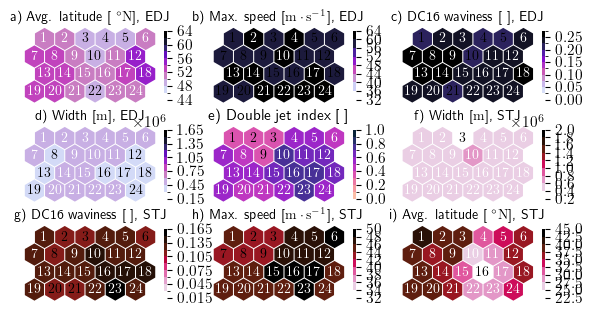

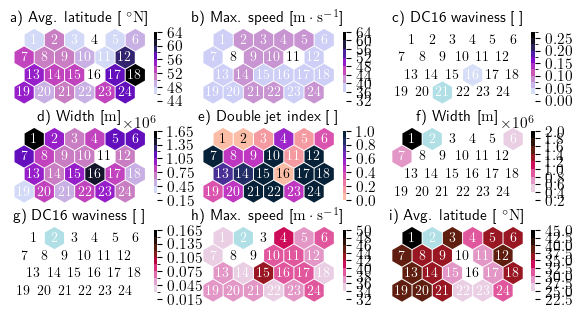

In [29]:
from string import ascii_lowercase

data_vars_and_jets = [
    ("mean_lat", "EDJ"),
    ("s_star", "EDJ"),
    ("wavinessDC16", "EDJ"),
    ("width", "EDJ"),
    ("double_jet_index", "STJ"),
    ("width", "STJ"),
    ("wavinessDC16", "STJ"),
    ("s_star", "STJ"),
    ("mean_lat", "STJ"),
]
fig1, axes1 = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes1 = axes1.flatten()
fig2, axes2 = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes2 = axes2.flatten()
for letter, (varname, jet), (j, ax1) in zip(ascii_lowercase, data_vars_and_jets, enumerate(axes1)):
    ax2 = axes2[j]
    if varname == "double_jet_index":
        cmap = colormaps.bubblegum_r
        ax1.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
        ax2.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    else:
        cmap = colormaps.gothic_r if jet == "EDJ" else colormaps.flamingo_r
        ax1.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {jet}", pad=2, fontsize=10)
        ax2.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    to_plot_1 = props_as_df_summer.filter(pl.col("jet") == jet)[varname]
    to_plot_1 = timeseries_on_map(to_plot_1, net.latest_bmus)[0]
    to_plot_2 = centers_props.filter(pl.col("jet") == jet)[varname].to_numpy()
    feature = np.concatenate([to_plot_1, to_plot_2])
    symmetric = infer_direction(np.nan_to_num(feature)) == 0
    levels = MaxNLocator(14 if symmetric else 10, symmetric=symmetric).tick_values(np.nanmin(feature), np.nanmax(feature))
    norm = BoundaryNorm(levels, cmap.N)
    cmap.set_bad(color="powderblue")
    fig1, ax1 = net.plot_on_map(
        to_plot_1,
        smooth_sigma=0,
        show=False,
        fig=fig1,
        ax=ax1,
        draw_cbar=True,
        cmap=cmap,
        norm=norm,
        discretify=False,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.8),
        numbering=True,
    )
    fig2, ax2 = net.plot_on_map(
        np.ma.masked_invalid(to_plot_2),
        smooth_sigma=0,
        show=False,
        fig=fig2,
        ax=ax2,
        draw_cbar=True,
        cmap=cmap,
        norm=norm,
        discretify=False,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.8),
        numbering=True,
    )
fig1.savefig(f'{FIGURES}/som_props/combined_indices_same_cbar.png')
fig2.savefig(f'{FIGURES}/som_props/combined_indices_on_map_same_cbar.png')

/storage/homefs/hb22g102/xpysom-dask/xpysom_dask/plots.py:276: UserWarning: Adding colorbar to a different Figure <Figure size 699.464x290 with 10 Axes> than <Figure size 699.464x290 with 9 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(ax.collections[0], ax=ax, **cbar_kwargs)
/storage/homefs/hb22g102/xpysom-dask/xpysom_dask/plots.py:276: UserWarning: Adding colorbar to a different Figure <Figure size 699.464x290 with 11 Axes> than <Figure size 699.464x290 with 10 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(ax.collections[0], ax=ax, **cbar_kwargs)
/storage/homefs/hb22g102/xpysom-dask/xpysom_dask/plots.py:276: UserWarning: Adding colorbar to a different Figure <Figure size 699.464x290 with 12 Axes> than <Figure size 699.464x290 with 11 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(ax.collections[0], ax=ax, **cbar_kwargs)
/storage/homefs/hb22g102/xpysom-dask/xpysom_dask/plots.py:276: UserWarning: Adding colorbar to a different Figure <Figure 

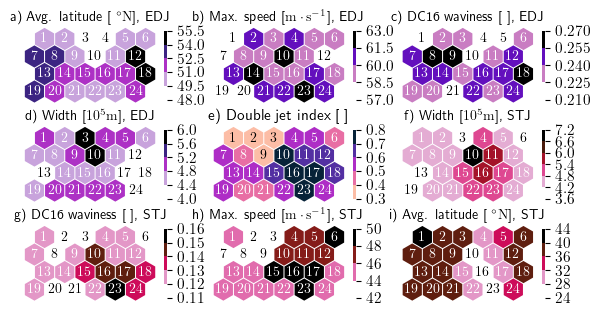

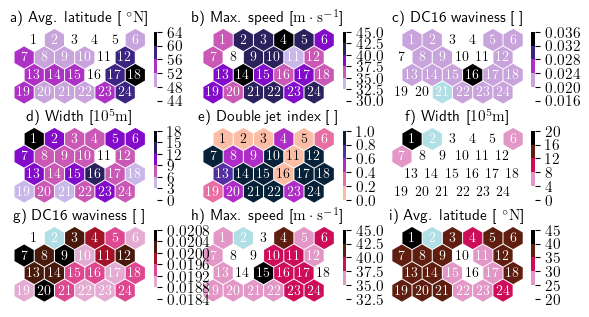

In [31]:
from string import ascii_lowercase

data_vars_and_jets = [
    ("mean_lat", "EDJ"),
    ("s_star", "EDJ"),
    ("wavinessDC16", "EDJ"),
    ("width", "EDJ"),
    ("double_jet_index", "STJ"),
    ("width", "STJ"),
    ("wavinessDC16", "STJ"),
    ("s_star", "STJ"),
    ("mean_lat", "STJ"),
]
fig1, axes1 = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes1 = axes1.flatten()
fig2, axes2 = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes2 = axes2.flatten()
for letter, (varname, jet), (j, ax1) in zip(ascii_lowercase, data_vars_and_jets, enumerate(axes1)):
    ax2 = axes2[j]
    if varname == "double_jet_index":
        cmap = colormaps.bubblegum_r
        ax1.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
        ax2.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    elif varname == "width":
        cmap = colormaps.gothic_r if jet == "EDJ" else colormaps.flamingo_r
        ax1.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [$10^5${UNITS.get(varname, '')}], {jet}", pad=2, fontsize=10)
        ax2.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [$10^5${UNITS.get(varname, '')}]", pad=2)
    else:
        cmap = colormaps.gothic_r if jet == "EDJ" else colormaps.flamingo_r
        ax1.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {jet}", pad=2, fontsize=10)
        ax2.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    to_plot_1 = props_as_df_summer.filter(pl.col("jet") == jet)[varname]
    to_plot_1 = timeseries_on_map(to_plot_1, net.latest_bmus)[0]
    to_plot_2 = centers_props.filter(pl.col("jet") == jet)[varname].to_numpy()
    if varname == "width":
        to_plot_1 = to_plot_1 / 1e5
        to_plot_2 = to_plot_2 / 1e5
    feature = np.concatenate([to_plot_1, to_plot_2])
    symmetric = infer_direction(np.nan_to_num(feature)) == 0
    levels = MaxNLocator(10 if symmetric else 6, symmetric=symmetric).tick_values(np.nanmin(feature), np.nanmax(feature))
    norm = BoundaryNorm(levels, cmap.N)
    cmap.set_bad(color="powderblue")
    fig1, ax1 = net.plot_on_map(
        to_plot_1,
        smooth_sigma=0,
        show=False,
        fig=fig1,
        ax=ax1,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.8),
        numbering=True,
    )
    fig2, ax2 = net.plot_on_map(
        np.ma.masked_invalid(to_plot_2),
        smooth_sigma=0,
        show=False,
        fig=fig2,
        ax=ax2,
        draw_cbar=True,
        cmap=cmap,
        discretify=True,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.8),
        numbering=True,
    )
fig1.savefig(f'{FIGURES}/som_props/combined_indices.png')
fig2.savefig(f'{FIGURES}/som_props/combined_indices_on_map.png')